In [42]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [43]:
#parameters
image_size = 64   # DCGAN likes 64
batch_size = 128
latent_dim = 100

In [44]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(), # converts to float AND divides by 255 (normalize).
    transforms.Normalize(mean=[0.5], std=[0.5])  # scale to [-1, 1]
])

# Load Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

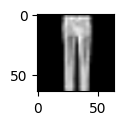

In [45]:
# get images and labels from loader
numbers, labels = next(iter(train_loader))

# visualize one image
images = numbers.numpy()
# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (1,1)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [46]:
class Discriminator(nn.Module):

    def __init__(self, latent_dim, output_size):
        super(Discriminator, self).__init__()

        self.disciminator = nn.Sequential(
            nn.Conv2d(1, image_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(),

            nn.Conv2d(image_size, image_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size*2),
            nn.LeakyReLU(),

            nn.Conv2d(image_size*2, image_size*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size*4),
            nn.LeakyReLU(),

            nn.Conv2d(image_size*4, image_size*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size*8),
            nn.LeakyReLU(),
            
            nn.Flatten(),
            nn.Linear(512*4*4, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # flatten image
        out = self.disciminator(x)

        return out

In [47]:
class Generator(nn.Module):

    def __init__(self, latent_dim, image_size):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, image_size*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(),

            nn.ConvTranspose2d(image_size*8, image_size*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(),

            nn.ConvTranspose2d(image_size*4, image_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(),

            nn.ConvTranspose2d(image_size*2, image_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(image_size),
            nn.ReLU(),
            
            nn.ConvTranspose2d(image_size, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.generator(x)
        return out

In [48]:
# build models and move to device
D = Discriminator(latent_dim, 1)
G = Generator(latent_dim, image_size)

# Send models to device
D = D.to(device)
G = G.to(device)

In [49]:
# Loss and optimizers
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = optim.Adam(G.parameters(), lr=0.0001)

In [52]:
# For generating latent noise
def generate_noise(batch_size, latent_size):
    z = torch.randn(batch_size, latent_size, device=device)
    z = z.view(batch_size, latent_dim, 1, 1)
    return z

Epoch [1/150], d_loss: 0.1225, g_loss: 5.4895
Epoch [2/150], d_loss: 0.0198, g_loss: 6.0818
Epoch [3/150], d_loss: 0.0448, g_loss: 5.0524
Epoch [4/150], d_loss: 0.0590, g_loss: 2.2219
Epoch [5/150], d_loss: 0.3050, g_loss: 4.4828
Epoch [6/150], d_loss: 0.0544, g_loss: 7.6382
Epoch [7/150], d_loss: 0.0737, g_loss: 5.8879
Epoch [8/150], d_loss: 0.0046, g_loss: 9.1744
Epoch [9/150], d_loss: 0.0281, g_loss: 6.4185
Epoch [10/150], d_loss: 0.0422, g_loss: 6.7263
Epoch [11/150], d_loss: 0.0238, g_loss: 9.6231
Epoch [12/150], d_loss: 0.0540, g_loss: 7.6625
Epoch [13/150], d_loss: 0.0822, g_loss: 5.4063
Epoch [14/150], d_loss: 0.0064, g_loss: 9.8950
Epoch [15/150], d_loss: 0.0105, g_loss: 4.6894
Epoch [16/150], d_loss: 0.0530, g_loss: 5.5789
Epoch [17/150], d_loss: 0.0257, g_loss: 6.5862
Epoch [18/150], d_loss: 0.1526, g_loss: 4.9130
Epoch [19/150], d_loss: 0.0523, g_loss: 4.6250
Epoch [20/150], d_loss: 0.0351, g_loss: 6.7583
Epoch [21/150], d_loss: 0.0227, g_loss: 7.6343
Epoch [22/150], d_loss

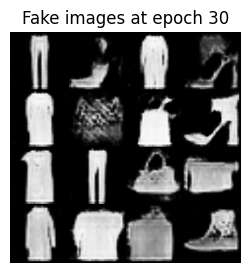

Epoch [31/150], d_loss: 0.0175, g_loss: 7.6459
Epoch [32/150], d_loss: 0.1568, g_loss: 5.8710
Epoch [33/150], d_loss: 0.0079, g_loss: 9.1461
Epoch [34/150], d_loss: 0.0018, g_loss: 9.1351
Epoch [35/150], d_loss: 0.0187, g_loss: 10.6564
Epoch [36/150], d_loss: 0.0067, g_loss: 7.2818
Epoch [37/150], d_loss: 0.0053, g_loss: 7.1303
Epoch [38/150], d_loss: 0.0067, g_loss: 5.2727
Epoch [39/150], d_loss: 0.0469, g_loss: 6.2587
Epoch [40/150], d_loss: 0.1982, g_loss: 7.9895
Epoch [41/150], d_loss: 0.0035, g_loss: 16.3818
Epoch [42/150], d_loss: 0.0114, g_loss: 7.5478
Epoch [43/150], d_loss: 0.0487, g_loss: 5.0632
Epoch [44/150], d_loss: 0.0139, g_loss: 7.2806
Epoch [45/150], d_loss: 0.0054, g_loss: 11.3890
Epoch [46/150], d_loss: 0.0925, g_loss: 6.5509
Epoch [47/150], d_loss: 0.0071, g_loss: 6.2420
Epoch [48/150], d_loss: 0.0101, g_loss: 8.2739
Epoch [49/150], d_loss: 0.0105, g_loss: 7.4212
Epoch [50/150], d_loss: 0.0103, g_loss: 8.8406
Epoch [51/150], d_loss: 0.0140, g_loss: 6.2865
Epoch [52/

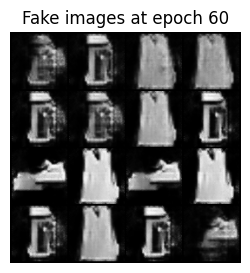

Epoch [61/150], d_loss: 0.0001, g_loss: 10.5080
Epoch [62/150], d_loss: 0.0000, g_loss: 12.7527
Epoch [63/150], d_loss: 0.0000, g_loss: 21.3141
Epoch [64/150], d_loss: 0.0057, g_loss: 26.0358
Epoch [65/150], d_loss: 0.0003, g_loss: 8.0440
Epoch [66/150], d_loss: 0.0001, g_loss: 10.0589
Epoch [67/150], d_loss: 0.0000, g_loss: 14.0935
Epoch [68/150], d_loss: 0.0000, g_loss: 16.1680
Epoch [69/150], d_loss: 0.0062, g_loss: 16.7021
Epoch [70/150], d_loss: 0.0026, g_loss: 7.9212
Epoch [71/150], d_loss: 0.0037, g_loss: 7.6224
Epoch [72/150], d_loss: 0.0022, g_loss: 7.8793
Epoch [73/150], d_loss: 0.0066, g_loss: 8.3694
Epoch [74/150], d_loss: 0.0002, g_loss: 9.9685
Epoch [75/150], d_loss: 0.0000, g_loss: 9.7229
Epoch [76/150], d_loss: 0.0083, g_loss: 30.5043
Epoch [77/150], d_loss: 0.0001, g_loss: 13.0392
Epoch [78/150], d_loss: 0.0003, g_loss: 9.2934
Epoch [79/150], d_loss: 0.0239, g_loss: 7.4483
Epoch [80/150], d_loss: 0.0144, g_loss: 8.4693
Epoch [81/150], d_loss: 0.0006, g_loss: 7.9070
Epo

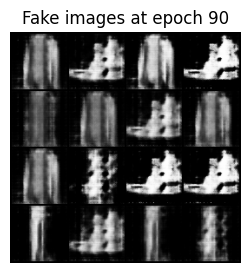

Epoch [91/150], d_loss: 0.0030, g_loss: 8.3007
Epoch [92/150], d_loss: 0.0010, g_loss: 8.5515
Epoch [93/150], d_loss: 0.0013, g_loss: 7.3787
Epoch [94/150], d_loss: 0.0346, g_loss: 18.1695
Epoch [95/150], d_loss: 0.0005, g_loss: 11.1803
Epoch [96/150], d_loss: 0.0012, g_loss: 6.1825
Epoch [97/150], d_loss: 0.0009, g_loss: 10.9347
Epoch [98/150], d_loss: 0.0019, g_loss: 10.8206
Epoch [99/150], d_loss: 0.0003, g_loss: 8.2475
Epoch [100/150], d_loss: 0.0017, g_loss: 8.5830
Epoch [101/150], d_loss: 0.0143, g_loss: 8.5780
Epoch [102/150], d_loss: 0.0006, g_loss: 8.8704
Epoch [103/150], d_loss: 0.0007, g_loss: 9.2150
Epoch [104/150], d_loss: 0.0009, g_loss: 11.5582
Epoch [105/150], d_loss: 0.0027, g_loss: 11.7937
Epoch [106/150], d_loss: 0.0022, g_loss: 8.3581
Epoch [107/150], d_loss: 0.0024, g_loss: 10.9031
Epoch [108/150], d_loss: 0.0016, g_loss: 14.7832
Epoch [109/150], d_loss: 0.0251, g_loss: 11.4296
Epoch [110/150], d_loss: 0.0071, g_loss: 6.0192
Epoch [111/150], d_loss: 0.0229, g_loss:

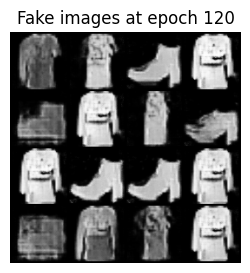

Epoch [121/150], d_loss: 0.0028, g_loss: 10.5340
Epoch [122/150], d_loss: 0.0010, g_loss: 7.7730
Epoch [123/150], d_loss: 0.0016, g_loss: 9.9858
Epoch [124/150], d_loss: 0.0032, g_loss: 8.7159
Epoch [125/150], d_loss: 0.0009, g_loss: 10.9559
Epoch [126/150], d_loss: 0.3550, g_loss: 17.3058
Epoch [127/150], d_loss: 0.0001, g_loss: 10.3341
Epoch [128/150], d_loss: 0.0003, g_loss: 12.6336


In [ ]:
num_epochs = 150

# Training loop
for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        real_images = real_images.view(-1, 1, image_size, image_size).to(device)
        batch_size_curr = real_images.size(0)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size_curr, 1).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

        # Train Discriminator
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        noise = generate_noise(batch_size_curr, latent_dim)
        fake_images = G(noise)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake

        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        noise = generate_noise(batch_size_curr, latent_dim)
        fake_images = G(noise)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)  # We want the fake images to be classified as real

        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

    # Generate and show fake images every 10 epochs
    if (epoch+1) % 30 == 0:
        with torch.no_grad():
            fake_images = fake_images.reshape(-1, 1, image_size, image_size)
            fake_images = fake_images[:16]
            grid = torchvision.utils.make_grid(fake_images, nrow=4, normalize=True)
            plt.figure(figsize=(3,3))
            plt.imshow(grid.permute(1,2,0).cpu())
            plt.axis('off')
            plt.title(f'Fake images at epoch {epoch+1}')
            plt.show()